**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [1]:
import os
import cv2
import time
import numpy as np
from IPython.display import clear_output

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn
import segmentation_models_pytorch as smp


import albumentations as A
import albumentations.augmentations as aug
from albumentations.pytorch import ToTensorV2

In [2]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union
    

In [4]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)
    

In [5]:
class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, aug):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.aug = aug

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]

        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        image = image.astype(np.float32)

        sample = self.aug(image=image, mask=mask)
        sample['mask'] = torch.unsqueeze(sample['mask'], 0)

        return sample


In [6]:
def compute_loss(loss, logits, gt):
    return loss(logits, gt)

In [7]:
def eval_model(model, data_generator, threshold=0.63):
    iou_metrics = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm.tqdm(data_generator):
            X_batch = batch["image"].to(device)
            y_batch = batch["mask"].to(device)
            
            probs = torch.sigmoid(model(X_batch))
            y_pred = (probs > threshold).int().data
            
            iou = calc_iou(y_pred.cpu().numpy(), y_batch.cpu().numpy())
            iou_metrics.append(iou)
    return np.mean(iou_metrics)


def train_model(model, loss_f, optimizer, train_data_generator):
    train_loss = []
    model.train()
    for batch in tqdm.tqdm(train_data_generator):
        opt.zero_grad()

        X_batch = batch["image"].to(device)
        y_batch = batch["mask"].to(device)

        predictions = model(X_batch)
        loss = compute_loss(loss_f, predictions, y_batch)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, name_model, loss_f, optimizer, train_data_generator, val_data_generator, num_epochs):
    
    max_val_accuracy = -1
    metrics = {'train_loss': [], 'iou': [] }
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        step = len(metrics['train_loss']) + 1
        
        start_time = time.time()

        train_loss = train_model(model, loss_f, optimizer, train_data_generator)
        iou_metrics = eval_model(model, val_data_generator)

        clear_output(True)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation iou: \t\t\t{:.2f} ".format(iou_metrics))

        metrics['train_loss'].append((step, train_loss))
        metrics['iou'].append((step, iou_metrics))

        if metrics["iou"][-1][1] > max_val_accuracy:
            max_val_accuracy = metrics["iou"][-1][1]
            torch.save(model, f'{name_model}.pth')


        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

    return metrics

In [8]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

X_test = get_paths("data/test/images")
y_test = get_paths("data/test/gt")

train_transform = A.Compose([
        aug.geometric.resize.Resize(288, 288),
        # aug.geometric.transforms.PadIfNeeded(min_height=384, min_width=384),
        aug.geometric.transforms.Affine(rotate=(-50, 50), scale=(0.7, 1), p=0.5),
        aug.transforms.ColorJitter(brightness=(0.7, 1.), contrast=(0.7, 1.), saturation=(0.4, 1.),  p=0.6),
        aug.transforms.ChannelShuffle(p=0.6),
        aug.transforms.Downscale(scale_min=0.2, scale_max=0.4, interpolation=cv2.INTER_NEAREST, p=0.6),
        aug.transforms.Emboss(p=0.8),
        ToTensorV2(),        
])


test_transform = A.Compose([
        aug.geometric.resize.Resize(288, 288),
        ToTensorV2(),
])

In [9]:
batch_size = 16

train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

train_dataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet = smp.Unet(
    encoder_name='resnet34', 
    encoder_depth=4,
    decoder_channels=(256, 128, 64, 16),
    decoder_use_batchnorm=True,
    encoder_weights=None, 
    in_channels=3,
    classes=1
).to(device)

loss = nn.BCEWithLogitsLoss()

Epoch 50 of 50 took 12.638s
  training loss (in-iteration): 	0.074822
  validation iou: 			0.73 


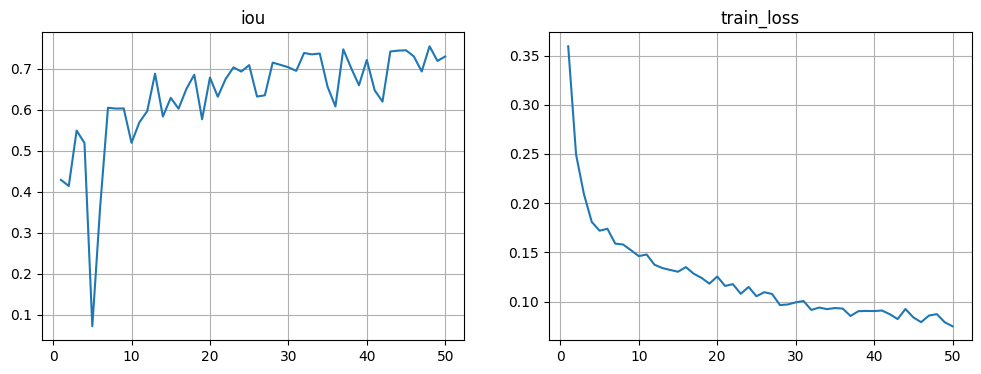

100%|███████████████████████████████████████████| 50/50 [10:41<00:00, 12.82s/it]


In [12]:
opt = torch.optim.Adam(unet.parameters(), lr=3e-4)
metrics = train_loop(unet, "Unet", loss, opt, train_dataLoader, test_dataLoader, 50)

Epoch 5 of 5 took 12.636s
  training loss (in-iteration): 	0.081593
  validation iou: 			0.75 


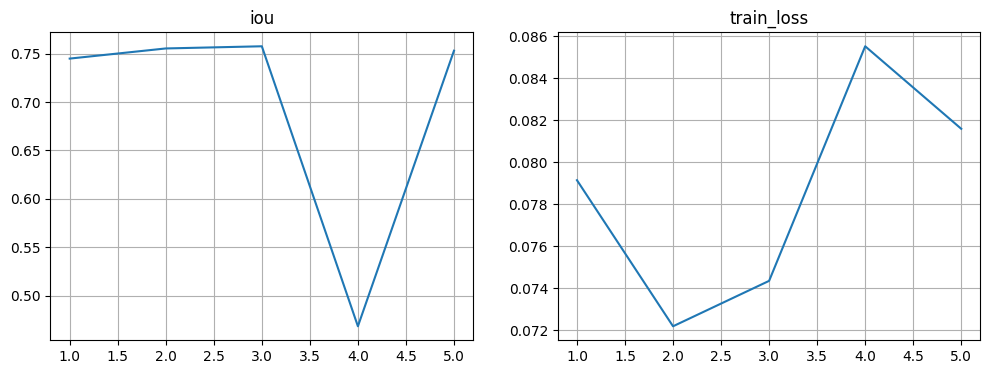

100%|█████████████████████████████████████████████| 5/5 [01:04<00:00, 12.88s/it]


In [13]:
opt = torch.optim.Adam(unet.parameters(), lr=3e-4)
metrics = train_loop(unet, "Unet", loss, opt, train_dataLoader, test_dataLoader, 5)

Epoch 2 of 2 took 12.633s
  training loss (in-iteration): 	0.060542
  validation iou: 			0.77 


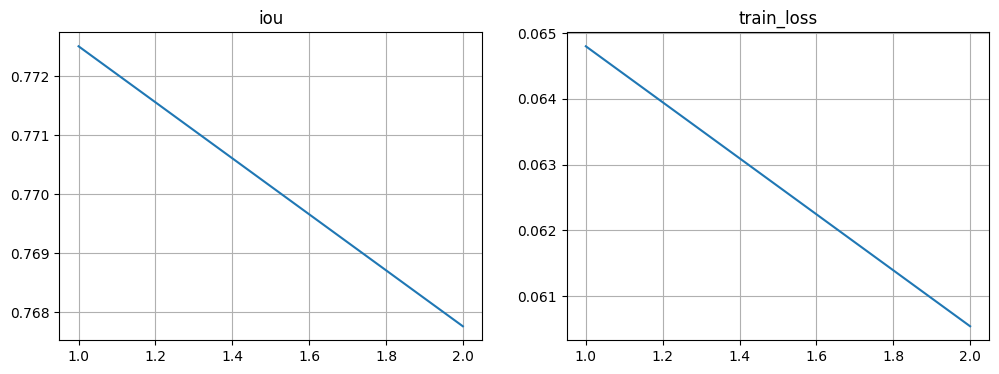

100%|█████████████████████████████████████████████| 2/2 [00:25<00:00, 12.85s/it]


In [14]:
opt = torch.optim.Adam(unet.parameters(), lr=3e-5)
metrics = train_loop(unet, "Unet", loss, opt, train_dataLoader, test_dataLoader, 2)

In [16]:
eval_model(unet, test_dataLoader, threshold=0.7)

100%|███████████████████████████████████████████| 14/14 [00:01<00:00,  9.39it/s]


0.7664758740212644